In [1]:
import numpy as np
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u
import matplotlib.pyplot as plt
plt.style.use('mplstyle')


In [2]:
pybdsf_catalog= "mosaic_image.pybdsf.srl.fits"
# --- Read original fluxes to define bins ---
with fits.open(pybdsf_catalog) as hdul:
    orig_data = hdul[1].data
original_fluxes = np.array(orig_data['Total_flux'])

# Define flux range and bins
flux_min, flux_max = original_fluxes.min(), original_fluxes.max()

# flux_thresh = flux_min/1.1 # Jy
flux_thresh = flux_min/1.01 # Jy

print(flux_min, flux_max)

0.010124571214612951 19.079440873276905


In [3]:
def find_sources_peak_int(pybdsf_catalog, flux_thresh):
    with fits.open(pybdsf_catalog) as hdul:
        ra = hdul[1].data["RA"]   # RA in degrees
        dec = hdul[1].data["DEC"]  # DEC in degrees
        peak_flux = hdul[1].data["Peak_flux"]  # Total flux density
        peak_flux_err = hdul[1].data["E_Peak_flux"]  # Flux error (check column name)
        int_flux = hdul[1].data["Total_flux"]  # Total flux density
        int_flux_err = hdul[1].data["E_Total_flux"]  # Total flux density
        local_rms = hdul[1].data["Isl_rms"]  # Flux error (check column name)
    
    # Apply flux threshold upon the integrated flux.
    bright_sources = int_flux > flux_thresh  # Boolean mask for bright sources

    # Filter sources
    ra = ra[bright_sources]
    dec = dec[bright_sources]
    peak_flux = peak_flux[bright_sources]
    peak_flux_err = peak_flux_err[bright_sources]  # Also filter flux errors
    int_flux = int_flux[bright_sources]  # Also filter flux errors
    int_flux_err = int_flux_err[bright_sources]  # Also filter flux errors
    local_rms = local_rms[bright_sources]  # Also filter flux errors

    return ra, dec, peak_flux, peak_flux_err, int_flux, int_flux_err, local_rms

In [4]:
ra, dec, peak_flux, peak_flux_err, int_flux, int_flux_err, local_rms = find_sources_peak_int(pybdsf_catalog, flux_thresh)

# Compute SNR and flux ratio
snr = peak_flux / local_rms  
flux_ratio = int_flux / peak_flux  
log_flux_ratio = np.log10(flux_ratio)  

# Compute flux ratio uncertainty following Chakraborty et al. (2019, Eq. 3)
flux_ratio_uncertainty = 2 * np.sqrt((int_flux_err / int_flux) ** 2 + (peak_flux_err / peak_flux) ** 2)

# Classify sources: Extended vs. Point-like
extended = log_flux_ratio > flux_ratio_uncertainty
point_like = ~extended

In [5]:
len(original_fluxes)

640

In [6]:
print(np.sum(point_like), np.sum(extended), np.sum(point_like)+ np.sum(extended))

print(np.sum(extended)/(np.sum(point_like)+ np.sum(extended)))

476 164 640
0.25625


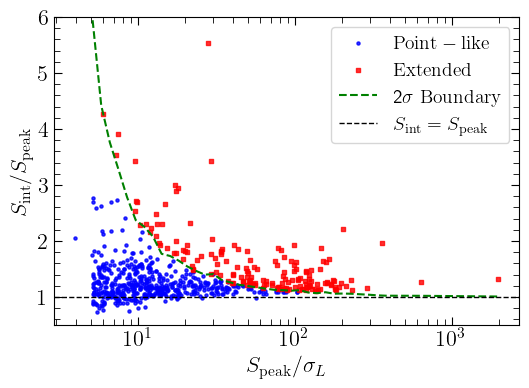

In [22]:
import numpy as np
import matplotlib.pyplot as plt


# Sort SNR for smooth 2-sigma boundary
sorted_idx = np.argsort(snr)
snr_sorted = snr[sorted_idx]
flux_ratio_unc_sorted = flux_ratio_uncertainty[sorted_idx]
sigma_threshold = 10**(flux_ratio_unc_sorted)  # convert log uncertainty to linear scale

# -------------------------------
# Create figure
# -------------------------------
fig, ax = plt.subplots(figsize=(6, 4))

# Plot sources
ax.scatter(snr[point_like], flux_ratio[point_like], 
           color='b', s=5, marker='o', alpha=0.8, label=r'$\rm Point-like$')
ax.scatter(snr[extended], flux_ratio[extended], 
           color='red', s=8, marker='s', alpha=0.8, label=r'$\rm Extended$')

# # Plot 2-sigma boundary
# ax.plot(snr_sorted, sigma_threshold, color='green', linestyle='--', linewidth=1.5,
#         label=r'2$\sigma$ Boundary')

# Smooth 2-sigma boundary
snr_min, snr_max = snr.min(), snr.max()
snr_grid = np.logspace(np.log10(snr_min), np.log10(snr_max), 50)  # 100 points for smooth curve
flux_ratio_unc_grid = np.interp(np.log10(snr_grid), np.log10(snr_sorted), flux_ratio_uncertainty[sorted_idx])
sigma_threshold_grid = 10**flux_ratio_unc_grid  # convert from log to linear scale

ax.plot(snr_grid, sigma_threshold_grid, color='green', linestyle='--', linewidth=1.5,
        label=r'2$\sigma \ \rm Boundary$')




# Reference line at S_int / S_peak = 1
ax.axhline(y=1.0, color='black', linestyle='--', linewidth=1, label=r'$S_{\rm int} = S_{\rm peak}$')

# Axes formatting
ax.set_xscale('log')
ax.set_xlabel(r'$S_{\rm peak} / \sigma_L$')
ax.set_ylabel(r'$S_{\rm int} / S_{\rm peak}$')
ax.set_ylim(0.5, 6.0)

# Grid and legend
# ax.grid(False, which='both', linestyle=':', linewidth=0.5, alpha=0.7)
ax.legend(fontsize=14, loc='upper right')
ax.tick_params(axis='both', which='major')

# Save figure
plt.savefig("flux_ratio_vs_snr.pdf", bbox_inches='tight')
